## Assignment 3a: Individual code

### Task 1: Patterns

### 1. Importing Libraries

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth

### 2. Read the dataset

In [165]:
df_train = pd.read_csv("../data/Groceries data train.csv")
print(df_train.shape)
print(df_train.head())

(27000, 7)
   Member_number        Date  itemDescription  year  month  day  day_of_week
0           3021  30/01/2015      frankfurter  2015      1   30            4
1           1292  24/10/2015             pork  2015     10   24            5
2           4206   4/04/2014  root vegetables  2014      4    4            4
3           4369  25/08/2015           onions  2015      8   25            1
4           1522   1/07/2014          waffles  2014      7    1            1


In [166]:
# check information of the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   Date             27000 non-null  object
 2   itemDescription  27000 non-null  object
 3   year             27000 non-null  int64 
 4   month            27000 non-null  int64 
 5   day              27000 non-null  int64 
 6   day_of_week      27000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.4+ MB


In [167]:
# Check for unique values ​​for each variable
df_train.nunique()

Member_number      3872
Date                728
itemDescription     167
year                  2
month                12
day                  31
day_of_week           7
dtype: int64

In [168]:
# Check for missing values
df_train.isnull().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

There are no missing values ​​in the training dataset.

In [169]:
# Check the data types of the variables
print(df_train.dtypes)

Member_number       int64
Date               object
itemDescription    object
year                int64
month               int64
day                 int64
day_of_week         int64
dtype: object


Date is not a datetime type, we need to convert it to datetime format.

In [170]:
# Convert the Date variable to datetime format
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d/%m/%Y')
# Check the data types of the variables again
print(df_train.dtypes)
# Check the number of transactions per day
print("\nThe number of transactions per day: \n", df_train.groupby('Date').size().describe())
# check the first 5 rows of the dataset
print(df_train.head())

Member_number               int64
Date               datetime64[ns]
itemDescription            object
year                        int64
month                       int64
day                         int64
day_of_week                 int64
dtype: object

The number of transactions per day: 
 count    728.000000
mean      37.087912
std        9.536607
min       11.000000
25%       30.000000
50%       36.000000
75%       43.000000
max       70.000000
dtype: float64
   Member_number       Date  itemDescription  year  month  day  day_of_week
0           3021 2015-01-30      frankfurter  2015      1   30            4
1           1292 2015-10-24             pork  2015     10   24            5
2           4206 2014-04-04  root vegetables  2014      4    4            4
3           4369 2015-08-25           onions  2015      8   25            1
4           1522 2014-07-01          waffles  2014      7    1            1


### 3. Analyse and visualise the data

#### 3.1 Visualize product distribution (product popularity)

In [171]:
# check each itemDescription's frequency
train_top10 = df_train['itemDescription'].value_counts().head(10)
train_bottom10 = df_train['itemDescription'].value_counts().tail(10)
print("The first 10 most common products: \n",train_top10)
print("The last 10 most common products: \n",train_bottom10)

The first 10 most common products: 
 itemDescription
whole milk          1709
other vegetables    1320
rolls/buns          1197
soda                1060
yogurt               928
root vegetables      733
tropical fruit       683
bottled water        666
sausage              637
citrus fruit         560
Name: count, dtype: int64
The last 10 most common products: 
 itemDescription
salad dressing           6
toilet cleaner           5
whisky                   4
make up remover          4
baby cosmetics           3
bags                     3
rubbing alcohol          3
frozen chicken           2
preservation products    1
kitchen utensil          1
Name: count, dtype: int64


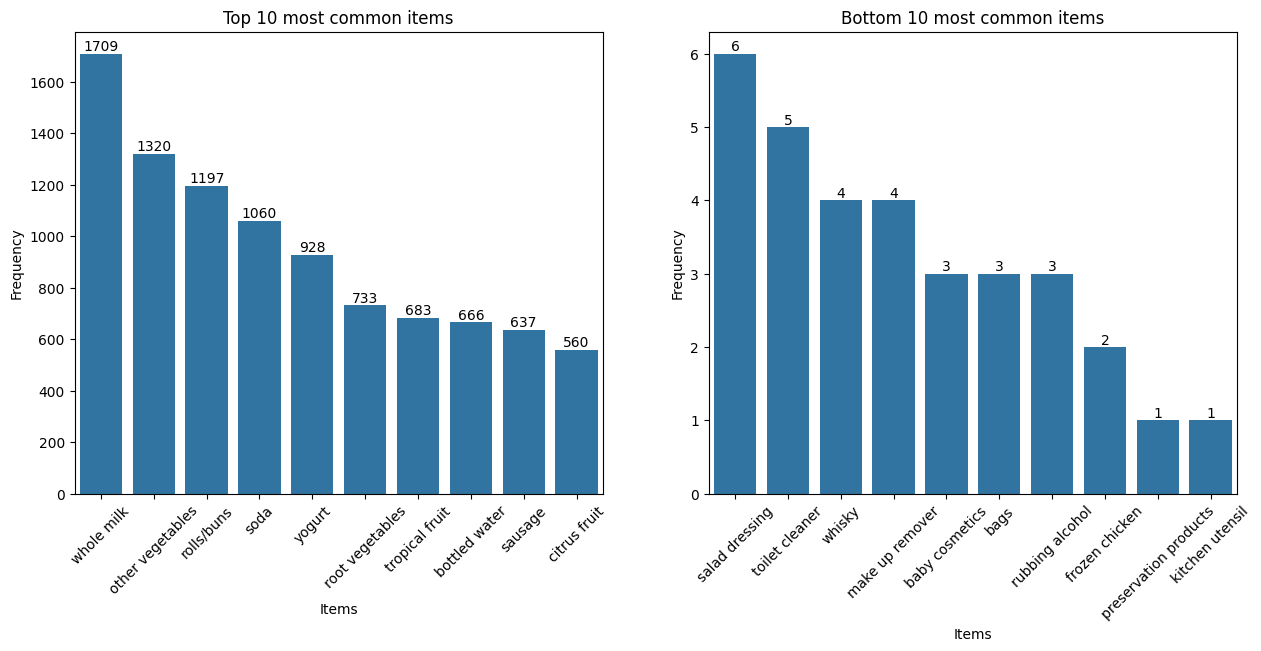

In [172]:
# visualize the distribution of itemDescription for top 10 and bottom 10
def plot_top_bottom_10(train_top10, train_bottom10):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=train_top10.index, y=train_top10.values, ax=ax[0])
    sns.barplot(x=train_bottom10.index, y=train_bottom10.values, ax=ax[1])
    ax[0].set_title('Top 10 most common items')
    ax[1].set_title('Bottom 10 most common items')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('Frequency')
    ax[1].set_xlabel('Items')
    ax[1].set_ylabel('Frequency')
    ax[0].tick_params(axis='x', rotation=45)
    ax[1].tick_params(axis='x', rotation=45)
    # show number on the top of the bar
    for index, value in enumerate(train_top10.values):
        ax[0].text(index, value, str(value), ha='center', va='bottom')
    for index, value in enumerate(train_bottom10.values):
        ax[1].text(index, value, str(value), ha='center', va='bottom')
    plt.show()

plot_top_bottom_10(train_top10, train_bottom10)

* The most frequent product is whole milk, which appears 1709 times, followed by other vegetables, rolls/buns, etc.
* Each product in the top 10 appears more than 500 times, which indicates that there are significant hot-selling products and are suitable for frequent item set analysis.
* The product frequency is decreasing, which is in line with the "long-tail distribution" hypothesis: a few products have extremely high frequencies, and most products have low frequencies.
* These high-frequency products are likely to constitute frequent item sets (such as "whole milk + yogurt"). I can consider setting min_support to 1%-2% of the number of transactions to avoid generating too many unimportant item sets.

#### 3.2 Visualize user activity distribution (analyzing shopping frequency)

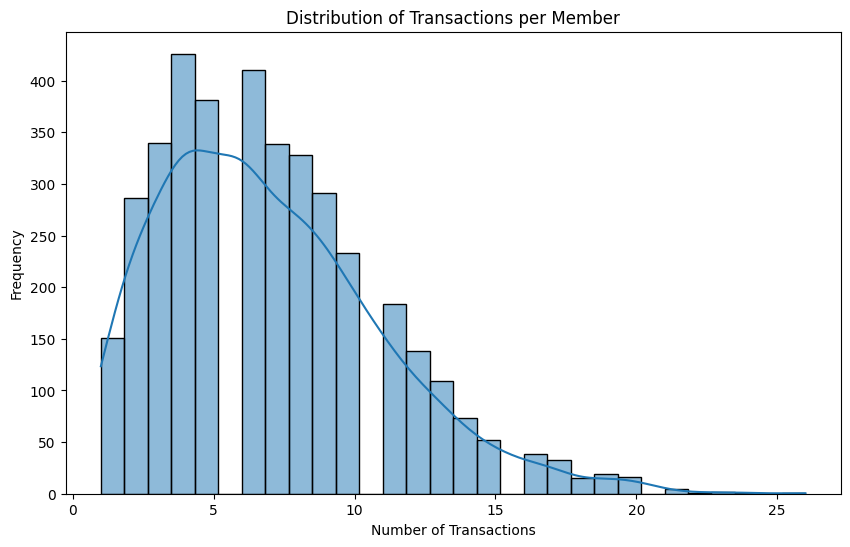

In [173]:
# Distribution of Transactions per Member
def plot_transactions_per_member(df_train):
    # Calculate the number of transactions per member
    transactions_per_member = df_train['Member_number'].value_counts()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(transactions_per_member, bins=30, kde=True)
    plt.title('Distribution of Transactions per Member')
    plt.xlabel('Number of Transactions')
    plt.ylabel('Frequency')
    plt.show()

plot_transactions_per_member(df_train)

* The overall data is biased to the right, indicating that the data is concentrated in low-frequency transactions, and it is necessary to pay attention to the "tail effect" in the analysis

#### 3.3 Analyze trading trends by time (holiday/weekend effects)

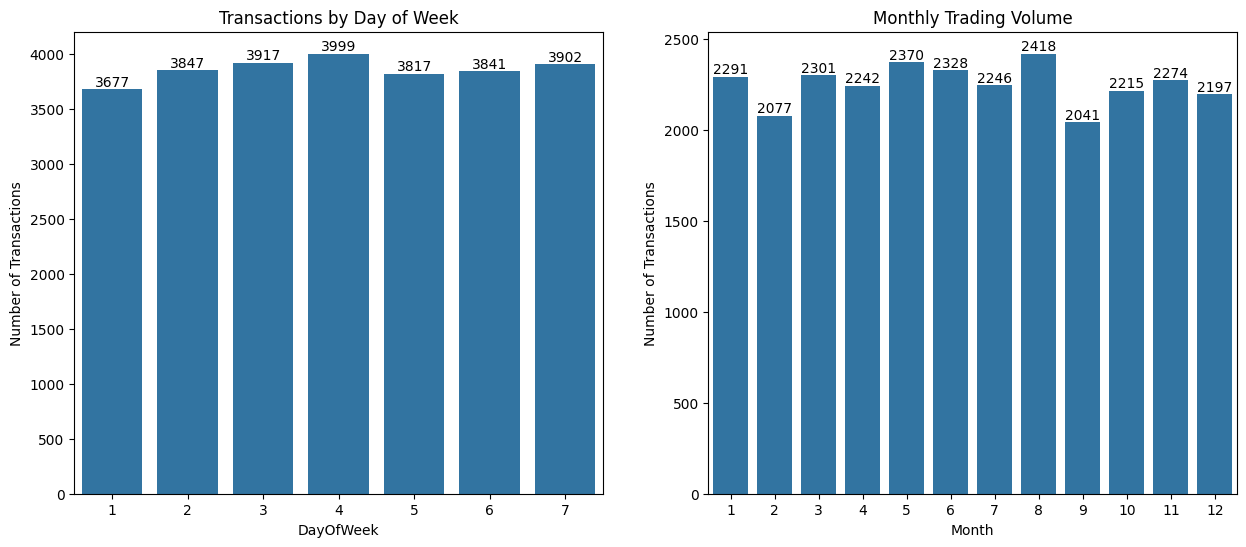

In [175]:
# Monthly Trading Volume and Weekly Trading Volume
def plot_weekly_and_monthly_trading_volume(df_train):
    # Calculate the number of transactions by week and month
    weekly_transactions = df_train.groupby('DayOfWeek').size()
    monthly_transactions = df_train.groupby('Month').size()

    # Plot the weekly and monthly trading volume on one row different subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sns.barplot(x=weekly_transactions.index, y=weekly_transactions.values, ax=ax[0])
    sns.barplot(x=monthly_transactions.index, y=monthly_transactions.values, ax=ax[1])
    ax[0].set_title('Transactions by Day of Week')
    ax[1].set_title('Monthly Trading Volume')
    ax[0].set_ylabel('Number of Transactions')
    ax[1].set_ylabel('Number of Transactions')
    # show number on the top of the bar
    for index, value in enumerate(weekly_transactions.values):
        ax[0].text(index, value, str(value), ha='center', va='bottom')
    for index, value in enumerate(monthly_transactions.values):
        ax[1].text(index, value, str(value), ha='center', va='bottom')
    plt.show()

plot_weekly_and_monthly_trading_volume(df_train)

* There is an obvious transaction peak in August, which may be related to the summer vacation or promotion, and the transaction is sluggish in February.

* There are seasonal and holiday effects at the monthly level, and the time dimension has mining value.

#### 3.4 Visualize how many items are purchased each time (Transaction "basket" size)

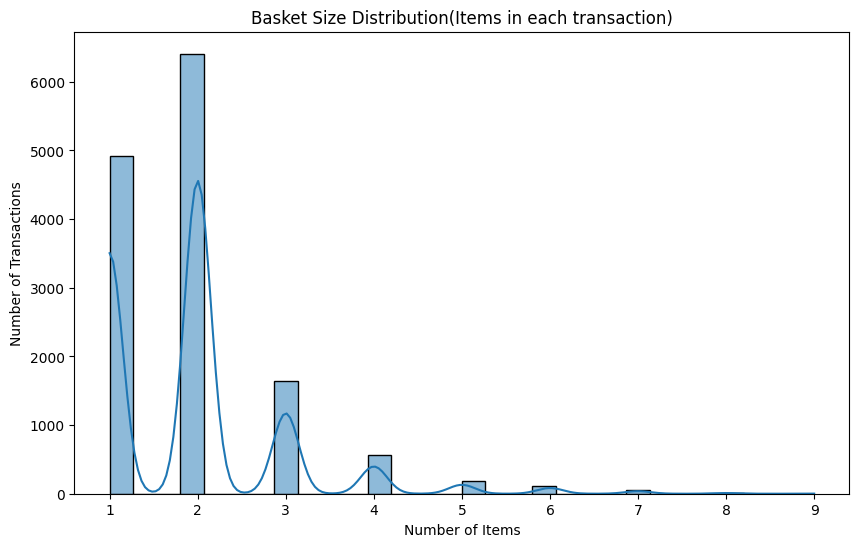

In [176]:
# Brasket size distribution(number of items in each transaction)
def plot_basket_size_distribution(df_train):
    # group by member_number and date, and count the number of items in each transaction
    basket_size = df_train.groupby(['Member_number', 'Date']).size()
    
    # Plot the basket size distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(basket_size, bins=30, kde=True)
    plt.title('Basket Size Distribution(Items in each transaction)')
    plt.xlabel('Number of Items')
    plt.ylabel('Number of Transactions')
    plt.show()
    
plot_basket_size_distribution(df_train)

* Skewed distribution: The basket size distribution is clearly right-skewed, that is, most transactions contain fewer items (1 to 3), while transactions containing more items (more than 4) are rare. This indicates that users tend to buy a small number of items in a single transaction.

#### 3.5 Visualize product co-occurrence matrix

Visualize co-occurrences matrix and normalized to similarity matrix between items to identify preliminary item associations.

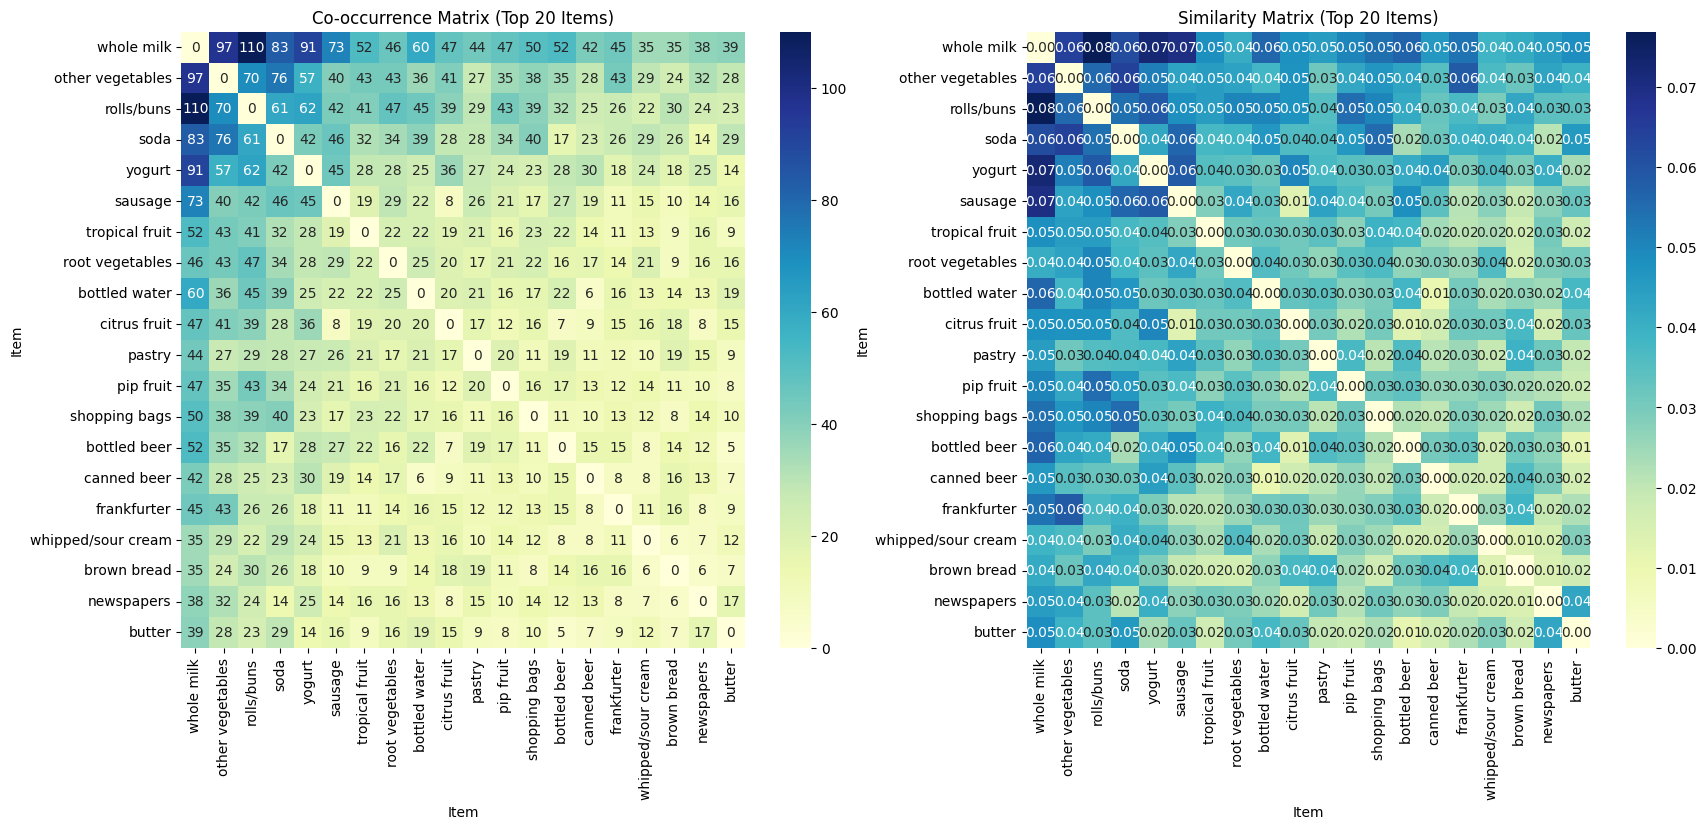

In [177]:
from collections import defaultdict
from itertools import combinations

# Each basket: Treat each user's purchase behavior on the same day as a basket (i.e. one transaction)
baskets_df = df_train.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)
# get the number of occurrences of each item
item_counts = df_train['itemDescription'].value_counts().to_dict()
#Count co-occurrences
co_matrix = defaultdict(int)
all_items = sorted(set(df_train['itemDescription'])) # All products that appeared in the dataset

def count_co_occurrences(baskets_df):
    for items in baskets_df:
        unique_items = sorted(set(items)) #sort the items and remove duplicates to ensure consistent order
        for item1, item2 in combinations(unique_items, 2): 
            co_matrix[(item1, item2)] += 1
            co_matrix[(item2, item1)] += 1 #symmetric co-occurrence

    # initialize co-occurrence matrix with zeros
    co_df = pd.DataFrame(0, index=all_items, columns=all_items)

    # fill the matrix with co-occurrence counts
    for (item1, item2), count in co_matrix.items():
        co_df.loc[item1, item2] = count

    return co_df

# construct similarity matrix
def construct_similarity_matrix():
    similarity_df = pd.DataFrame(0.0, index=all_items, columns=all_items)
    for (item1, item2), count in co_matrix.items():
       if item1 in item_counts and item2 in item_counts:
           sim = count / np.sqrt(item_counts[item1] * item_counts[item2])
           similarity_df.loc[item1, item2] = sim
    return similarity_df

# visualize the co-occurrence matrix and similarity matrix(select top 20 items)
def plot_co_occurrence_and_similarity_matrix(co_df, similarity_df):
    top_20_items = co_df.sum().sort_values(ascending=False).head(20).index
    co_df_top20 = co_df.loc[top_20_items, top_20_items]
    similarity_df_top20 = similarity_df.loc[top_20_items, top_20_items]
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.heatmap(co_df_top20, cmap='YlGnBu', annot=True, fmt='d', ax=ax[0])
    sns.heatmap(similarity_df_top20, cmap='YlGnBu', annot=True, fmt='.2f', ax=ax[1])
    ax[0].set_title('Co-occurrence Matrix (Top 20 Items)')
    ax[1].set_title('Similarity Matrix (Top 20 Items)')
    ax[0].set_xlabel('Item')
    ax[0].set_ylabel('Item')
    ax[1].set_xlabel('Item')
    ax[1].set_ylabel('Item')
    plt.show()

co_df = count_co_occurrences(baskets_df)
similarity_df = construct_similarity_matrix()
plot_co_occurrence_and_similarity_matrix(co_df, similarity_df)

* High frequency co-occurrence: **whole milk** is a **core product** and has strong co-occurrence with multiple products.

### 4. Pre-processing data

In [179]:
# preprocess transactions data
def preprocess_transactions(df): 
    # group by member_number and date, and collect item list
    transactions = baskets_df.values.tolist()
    
    # convert to one-hot encoding
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
        
    return df_encoded, transactions

df_encoded, transactions = preprocess_transactions(df_train)
df_encoded

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13896,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13897,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13898,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13899,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 5. FP-Growth Implement

#### 5.1 Function and class definitions

In [188]:
class FrequentPatternMiner:
    def __init__(self, min_support=0.005, min_confidence=0.01):
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_patterns = None
        self.rules = None
    
    # find frequent patterns
    def find_patterns(self, df_encoded):
        self.frequent_patterns = fpgrowth(df_encoded, 
                                        min_support=self.min_support, 
                                        use_colnames=True)
        return self.frequent_patterns
  
    # generate association rules
    def generate_rules(self):
        self.rules = association_rules(self.frequent_patterns, 
                                     metric="confidence",
                                     min_threshold=self.min_confidence)
        return self.rules
    
    # visualize top N frequent patterns(according to support)
    def visualize_top_frequent_patterns(self, top_n=20):
        if self.frequent_patterns is None or self.frequent_patterns.empty:
            print("No frequent patterns found")
            return

        if not hasattr(self.frequent_patterns, 'support') or not hasattr(self.frequent_patterns, 'itemsets'):
            print("The format of frequent_patterns is not correct")
            return
        
        try:
            # sort the frequent patterns by support in descending order
            top_patterns = self.frequent_patterns.sort_values(by='support', ascending=False).head(top_n)
            
            # convert frozenset to string for plotting
            top_patterns['itemsets_str'] = top_patterns['itemsets'].apply(lambda x: ', '.join(list(x)))

            plt.figure(figsize=(12, max(6, top_n * 0.4))) # adjust height dynamically, minimum height is 6
            bars = plt.barh(top_patterns['itemsets_str'], top_patterns['support'], color='skyblue')
            plt.xlabel('Support')
            plt.ylabel('Frequent Itemsets')
            plt.title(f'Top {top_n} Frequent Itemsets (Sorted by Support)')
            plt.gca().invert_yaxis() # put the highest support at the top
            
            for bar in bars:
                plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                         f'{bar.get_width():.4f}', 
                         va='center', ha='left', fontsize=8, color='black')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error when plotting: {e}")

    def visualize_rules_scatter(self, metric_x='support', metric_y='confidence', color_by='lift', top_n_rules=100):
        """visualize rules scatter plot

        Args:
            metric_x (str): X-axis used metric (e.g. 'support', 'confidence', 'lift').
            metric_y (str): Y-axis used metric.
            color_by (str): The metric used to determine the color of the points (e.g. 'lift', 'support', 'confidence').
            top_n_rules (int, optional): Maximum number of rules to display, sorted by confidence and lift. None shows all.
        """
        if self.rules is None or self.rules.empty:
            print("No association rules generated")
            return

        required_cols = {metric_x, metric_y, color_by, 'antecedents', 'consequents'}
        if not required_cols.issubset(self.rules.columns):
            print(f"Missing required columns: {required_cols}")
            return

        # use a copy to avoid modifying the original data
        rules_to_plot = self.rules.copy() 

        if top_n_rules and top_n_rules < len(rules_to_plot):
            # ensure the columns for sorting exist
            sort_cols = ['confidence', 'lift']
            if not all(col in rules_to_plot.columns for col in sort_cols):
                print(f"Missing required columns: {sort_cols}")
            else:
                rules_to_plot = rules_to_plot.sort_values(by=sort_cols, ascending=[False, False]).head(top_n_rules)

        try:
            plt.figure(figsize=(12, 8))
            
            # according to the value of color_by, determine the size of the point, if the metric is lift, the effect is more obvious
            # also ensure the size of the point is not too large or too small
            if color_by in rules_to_plot.columns:
                point_sizes = rules_to_plot[color_by] * 100 if color_by == 'lift' else rules_to_plot[color_by] * 200 + 20
                point_sizes = point_sizes.clip(10, 500) # limit the range of point size
            else:
                point_sizes = 50 # default size

            scatter = plt.scatter(rules_to_plot[metric_x], rules_to_plot[metric_y], 
                                  alpha=0.6, 
                                  c=rules_to_plot[color_by] if color_by in rules_to_plot.columns else None,
                                  s=point_sizes,
                                  cmap='viridis')
            
            plt.xlabel(metric_x.capitalize())
            plt.ylabel(metric_y.capitalize())
            plt.title(f'Association Rules: {metric_x.capitalize()} vs. {metric_y.capitalize()} ({color_by.capitalize()} as Color/Size)')
            
            if color_by in rules_to_plot.columns:
                cbar = plt.colorbar(scatter) 
                cbar.set_label(color_by.capitalize())
            
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error when plotting: {e}")

#### 5.2 Pattern Mining

      support                   itemsets  itemset_length
0    0.039781                   (pastry)               1
1    0.064312                   (yogurt)               1
2    0.045249                  (sausage)               1
3    0.074095                     (soda)               1
4    0.006762       (pickled vegetables)               1
..        ...                        ...             ...
392  0.001511      (waffles, whole milk)               2
393  0.001367          (whole milk, oil)               2
394  0.001007                (soda, oil)               2
395  0.001007  (hard cheese, whole milk)               2
396  0.001079  (hard cheese, rolls/buns)               2

[397 rows x 3 columns]


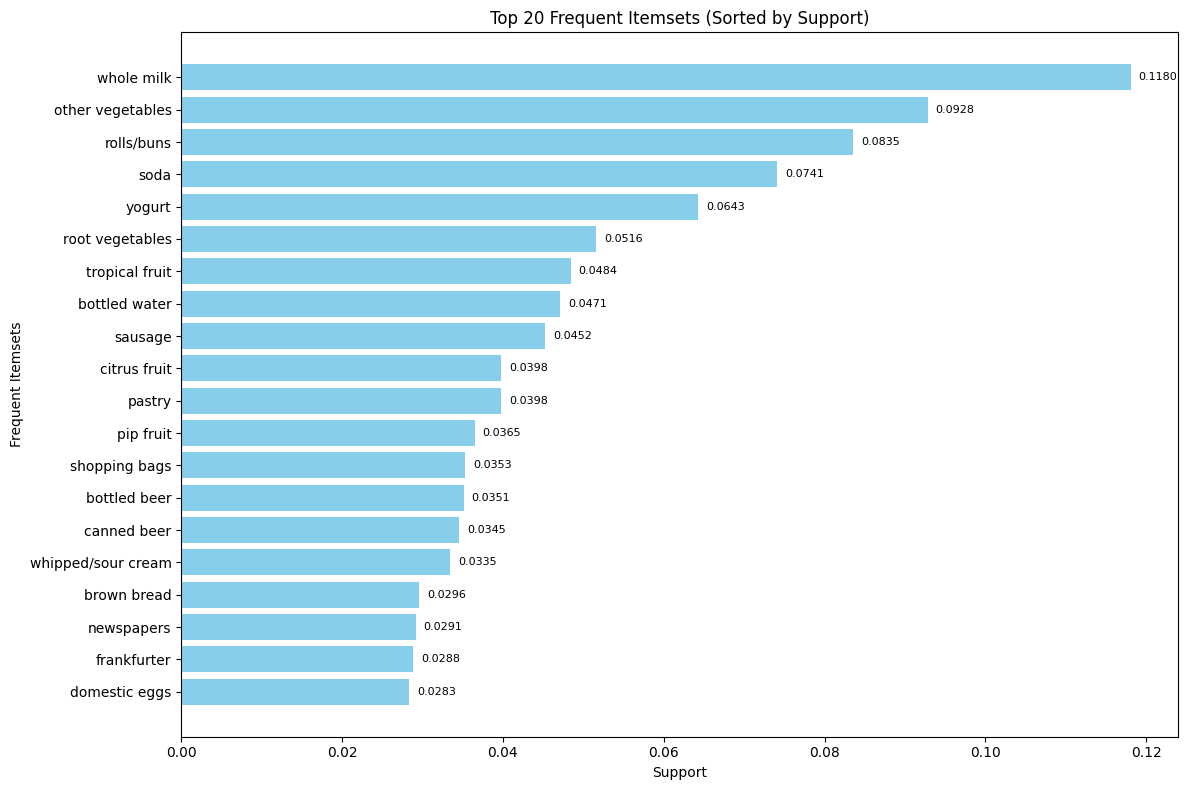

In [190]:
# initialize the model
pattern_miner = FrequentPatternMiner(min_support=0.001, min_confidence=0.05)

# find frequent patterns
frequent_patterns = pattern_miner.find_patterns(df_encoded)
# add itemset_length column to frequent_patterns
if frequent_patterns is not None:
    frequent_patterns['itemset_length'] = frequent_patterns['itemsets'].apply(lambda x: len(x))

# save the frequent patterns to a csv file
frequent_patterns.to_csv('../data/frequent_patterns.csv', index=False)
    
print(frequent_patterns)

pattern_miner.visualize_top_frequent_patterns(top_n=20)

* whole milk has the **highest support of 0.1180** (about 11.8% of transactions include whole milk). It is followed by other vegetables with a support of 0.0928. The support gradually decreases from the highest 0.1180, forming a **long tail effect**.

#### 5.3 Generate association rules

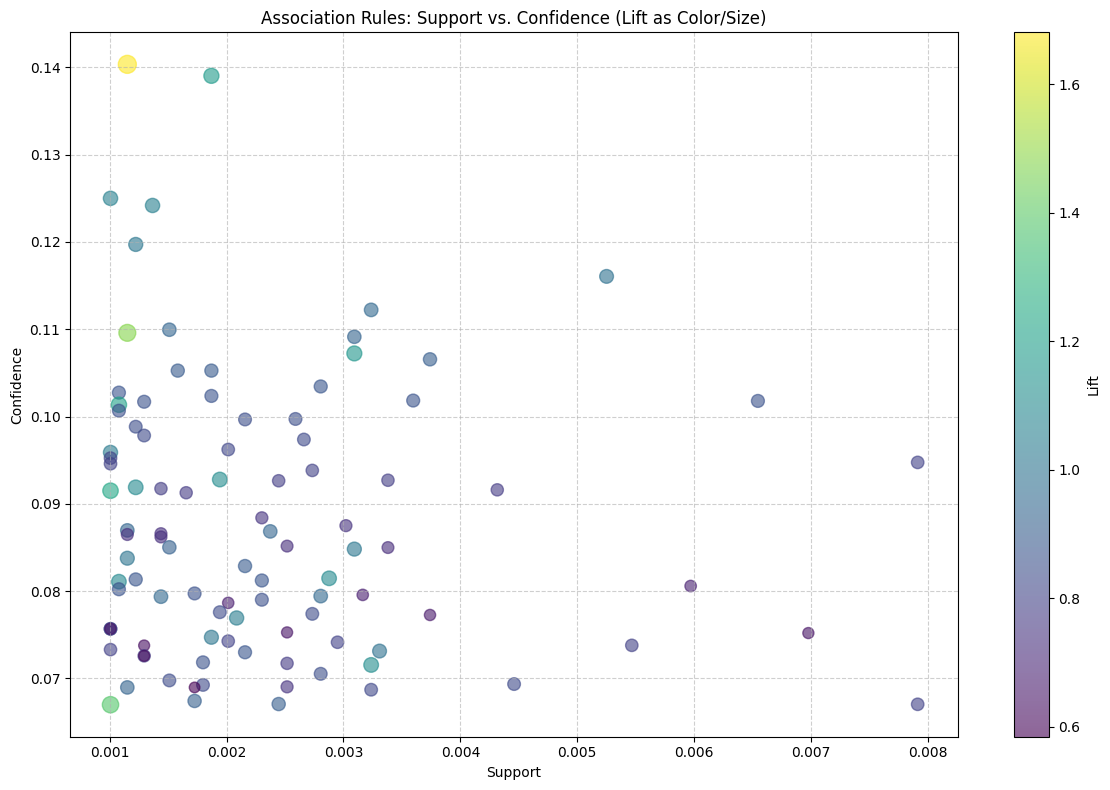

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
25,(rolls/buns),(whole milk),0.083519,0.118049,0.007913,0.094746,0.802598,1.0,-0.001946,0.974258,-0.211585,0.040862,-0.026422,0.080889
24,(whole milk),(rolls/buns),0.118049,0.083519,0.007913,0.067032,0.802598,1.0,-0.001946,0.982329,-0.218063,0.040862,-0.017989,0.080889
75,(other vegetables),(whole milk),0.092799,0.118049,0.006978,0.075194,0.636971,1.0,-0.003977,0.953660,-0.385836,0.034227,-0.048591,0.067152
76,(whole milk),(other vegetables),0.118049,0.092799,0.006978,0.059110,0.636971,1.0,-0.003977,0.964195,-0.392546,0.034227,-0.037135,0.067152
3,(yogurt),(whole milk),0.064312,0.118049,0.006546,0.101790,0.862266,1.0,-0.001046,0.981898,-0.145820,0.037234,-0.018436,0.078622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,(hamburger meat),(yogurt),0.016689,0.064312,0.001007,0.060345,0.938315,1.0,-0.000066,0.995778,-0.062667,0.012590,-0.004240,0.038002
90,(dessert),(rolls/buns),0.017553,0.083519,0.001007,0.057377,0.686993,1.0,-0.000459,0.972267,-0.316828,0.010065,-0.028524,0.034718
145,(napkins),(rolls/buns),0.017840,0.083519,0.001007,0.056452,0.675912,1.0,-0.000483,0.971313,-0.328044,0.010036,-0.029534,0.034255
68,(chocolate),(sausage),0.018128,0.045249,0.001007,0.055556,1.227787,1.0,0.000187,1.010913,0.188952,0.016148,0.010795,0.038907


In [ ]:
# generate association rules
rules = pattern_miner.generate_rules()
pattern_miner.visualize_rules_scatter()
# order the rules by support,confidence,lift
rules = rules.sort_values(by=['support', 'confidence', 'lift'], ascending=[False, False, False])
# save the rule to a csv file
rules.to_csv('../data/rules.csv', index=False)
rules

### 6. Refernece

[1] Kyasar (2023) 'Recommender Systems: What Long-Tail Tells', Medium, 5 May. Available at: https://medium.com/@kyasar.mail/recommender-systems-what-long-tail-tells-91680f10a5b2 (Accessed: 27 May 2025).

[2] Bala, A., Shuaibu, M.Z., Lawal, Z.K. and Zakari, R.Y. (2016) 'Performance analysis of Apriori and FP-Growth algorithms (association rule mining)', International Journal of Computer Applications in Technology, vol. 7, no. 2, pp. 279–293. Available at: https://www.researchgate.net/publication/329515220_Performance_Analysis_of_Apriori_and_FP-Growth_Algorithms_Association_Rule_Mining (Accessed: 27 May 2025).

[3] University of Adelaide (2025) 'Module 9: Workshop 2', MyUni. Available at: https://myuni.adelaide.edu.au/courses/101178/pages/module-9-workshop-2?module_item_id=3603491 (Accessed: 27 May 2025).